In [12]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import seaborn as sns
import pandas as pd
from environment.TheoreticalMarket import *

In [13]:
filename = "sim_results/market-marl-nash-3-05-07-2022-00-17-5840_results.pkl"
# .pkl based on an older version, in the new version "res.avg_epoch_rewards" and is renamed to "res.avg_episode_rewards"

with open(filename, 'rb') as f:
    res = pkl.load(f)

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps, "Nash Net Loss": res.losses_nash}
data_losses_df = pd.DataFrame(data=data_losses)

In [14]:
res.marl_params

{'epochs': 40,
 'explore_epsilon': 0.05,
 'max_steps': 30,
 'sync_freq': 20,
 'mem_size': 101333,
 'turbo_max_evals': 5,
 'turbo_batch_size': 5,
 'turbo_n_init': 5,
 'batch_size': 10}

In [15]:
res.mdp_env.beta0, res.mdp_env.beta1, res.mdp_env.beta2

(15, -1.05, -3.1)

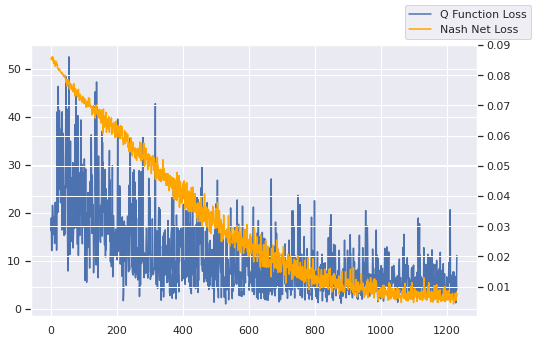

In [16]:
# import matplotlib.pyplot as plt

ax = data_losses_df.plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()

data_losses_df.plot(y="Nash Net Loss", ax=ax2, legend=False, color="orange")

ax.figure.legend()


In [17]:
from scipy.ndimage.interpolation import shift
import copy

# Market parameters
beta0 = res.mdp_env.beta0
beta1 = res.mdp_env.beta1
beta2 = res.mdp_env.beta2
a = 0.1

sm = 4
def moving_average(x, w=sm+1):
    return np.convolve(x, np.ones(w), 'valid') / w

def est_revenue_from_refprice(crp):
    demand = beta0 + beta1*crp[1] + beta2*(crp[1] - crp[0])
    return demand * crp[1]

ref_prices = res.state_tracker[:,-1]
episode_rewards = res.episode_rewards[:,-1]

joint_actions = res.episode_actions
episode_joint_actions = joint_actions[:,-1]

prices = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[0] for r in ref_prices])
devs = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[1] for r in ref_prices])
demand = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[2] for r in ref_prices])

y = ref_prices
x = prices[0]
X, Y = np.meshgrid(x, y) 
z = devs

nash_eps_bounds = [get_eps0_range(ref_price, Y, X, z) for ref_price in ref_prices ]
nash_lower_bound =  [v[0] for v in nash_eps_bounds]
nash_upper_bound =  [v[1] for v in nash_eps_bounds]

computed_ref_price = np.mean(res.episode_actions[:,-1, :], axis =1)
computed_avg_action = shift(computed_ref_price, -1, cval=computed_ref_price[-1])
computed_ref_price_pair = np.array([computed_ref_price, computed_avg_action]).T

nash_eps_bounds_all_ep = [get_eps0_range(ref_price, Y, X, z) for ref_price in computed_ref_price]
nash_lower_bound_all_ep =  [v[0] for v in nash_eps_bounds_all_ep]
nash_upper_bound_all_ep =  [v[1] for v in nash_eps_bounds_all_ep]

ref_prices = res.state_tracker[:,-1]

episode_rewards = res.episode_rewards[:,-1]

joint_actions = res.episode_actions
episode_joint_actions = joint_actions[:,-1]

prices = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[0] for r in ref_prices])
devs = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[1] for r in ref_prices])
demand = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[2] for r in ref_prices])

y = ref_prices
x = prices[0]
X, Y = np.meshgrid(x, y) 
z = devs

nash_lower_bound_ref_pair = copy.deepcopy(computed_ref_price_pair)
nash_upper_bound_ref_pair = copy.deepcopy(computed_ref_price_pair)
nash_lower_bound_ref_pair[:, 1] = nash_lower_bound_all_ep
nash_upper_bound_ref_pair[:, 1] = nash_upper_bound_all_ep
nash_lower_bound_all_rev_ep =  [est_revenue_from_refprice(v) for v in nash_lower_bound_ref_pair]
nash_upper_bound_all_rev_ep =  [est_revenue_from_refprice(v) for v in nash_upper_bound_ref_pair]

/tmp/ipykernel_26459/4239838212.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.gamma / self.demand_func(x)) - (1 / x)
/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  return self.gamma / (self.demand_func(x) * x )
/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:51: RuntimeWarning: invalid value encountered in double_scalars
  square_term = np.max([0, np.power(c1, 2) - c1 + 4*(c2 -1)*c2 - 2*c2])


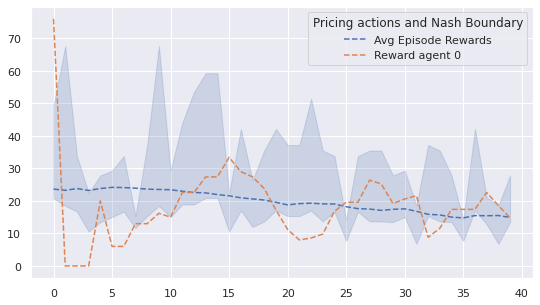

In [18]:
all_rewards = res.episode_rewards
agent_ind = 2
x = res.episode_rewards[:, -1, agent_ind]
smoothed_episode_rewards = moving_average(x)
start = x[0:sm]

# episode rewards all agents
sns.set()
plt.figure(figsize=(9,5))
x = np.arange(len(all_rewards))

plt.plot(x, res.avg_epoch_rewards, '--', label='Avg Episode Rewards')
plt.plot(x, np.concatenate([start, smoothed_episode_rewards]), '--', label='Reward agent 0')
plt.fill_between(x, nash_lower_bound_all_rev_ep, nash_upper_bound_all_rev_ep, color='b', alpha=0.2)
plt.legend(title='Pricing actions and Nash Boundary')

plt.show()
